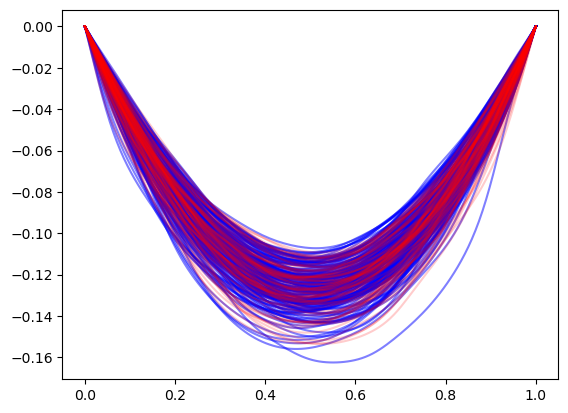

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import modules
import utils

datafile = 'data/ell0.1_d15_n2048_ksigma0.316.npz'
data = np.load(datafile)

x = torch.tensor(data['x'], dtype=torch.float32)
u_data = torch.tensor(data['u_sols'], dtype=torch.float32).T
n_total = u_data.shape[0]
n_train = 256
n_val = int(n_train * 0.3)
n_train = n_train - n_val
u_train = u_data[:n_train]
u_val = u_data[n_train:n_train+n_val]

plt.figure()
plt.plot(x, u_train.T, color='blue', alpha=0.5)
plt.plot(x, u_val.T, color='red', alpha=0.2)

In [2]:
latent_dim = 32
layers = [128, 64, latent_dim]
# layers = [128, 64, 32, latent_dim]
activation = nn.Tanh()

vae = modules.VAE(
    encoder=modules.SimpleFNN(layers, activation),
    decoder=modules.SimpleFNN(layers[::-1], activation),
    latent_dim=latent_dim
    )

In [4]:
# train the vae
epochs = 10000

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)

def loss_fn(x, x_hat, mean, log_var):
    kl_div = -0.5 * torch.sum(1 + log_var - mean**2 - log_var.exp())
    reconstruction_loss = nn.MSELoss()(x, x_hat)
    return reconstruction_loss + kl_div

for epoch in range(epochs):
    optimizer.zero_grad()
    u_hat, mean, log_var = vae(u_train)
    loss = loss_fn(u_train, u_hat, mean, log_var)
    loss.backward()
    optimizer.step()
    if epochs < 20 or epoch % (epochs//20) == 0 or epoch == epochs - 1:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 59.991790771484375
Epoch 500, Loss: 0.1580345779657364
Epoch 1000, Loss: 0.1250465363264084
Epoch 1500, Loss: 0.09810957312583923
Epoch 2000, Loss: 0.07285355031490326
Epoch 2500, Loss: 0.05002475157380104
Epoch 3000, Loss: 0.031071031466126442
Epoch 3500, Loss: 0.017122339457273483
Epoch 4000, Loss: 0.00839910376816988
Epoch 4500, Loss: 0.003895984962582588
Epoch 5000, Loss: 0.0018739752704277635
Epoch 5500, Loss: 0.0010074229212477803
Epoch 6000, Loss: 0.0006060362211428583
Epoch 6500, Loss: 0.00040342993452213705
Epoch 7000, Loss: 0.00029276215354911983
Epoch 7500, Loss: 0.00021871377248317003
Epoch 8000, Loss: 0.00017298250168096274
Epoch 8500, Loss: 0.00014827716222498566
Epoch 9000, Loss: 0.00012901423906441778
Epoch 9500, Loss: 0.00011503471614560112
Epoch 9999, Loss: 0.00010680176637833938


Text(0.5, 1.0, 'MMD: 6.44e-04')

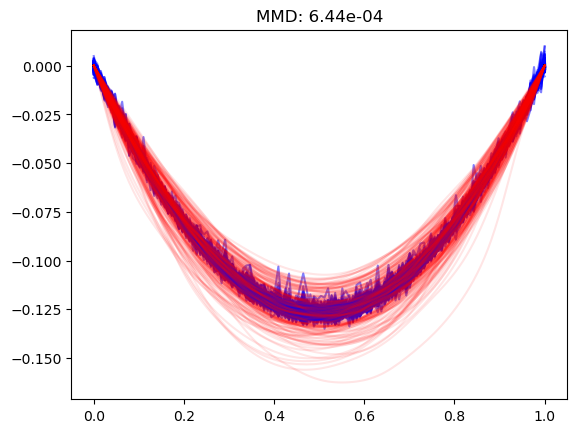

In [11]:
n_samples = 500
u_hat = vae.sample(n_samples)
alphas = [0.1, 0.2, 0.5, 1.0]
mmd = utils.mmd2_rq_mix(u_hat, u_train, alphas)

plt.figure()
plt.plot(x, u_hat.T.detach(), color='blue', alpha=0.5)
plt.plot(x, u_train.T, color='red', alpha=0.1)
plt.title(f'MMD: {mmd.item():.2e}')